University of Zagreb<br/>
Faculty of Electrical Engineering and Computing<br/>
Department of Electronic Systems and Information Processing

Academic year 2021/2022

## **6th laboratory exercise: Detection of image features**

*Digital Image Processing and Analysis* (183463)

Date: 2022-03-10

Please send any feedback (corrections, comments, suggestions etc.) regarding this document to branimir.filipovic@fer.hr.

© University of Zagreb Faculty of Electrical Engineering and Computing, 2021.

Permission is granted to make and distribute copies of this instructions provided the copyright notice and this permission notice are preserved on all copies.

# Introduction

Instructions for laboratory exercises for the course *Digital Image Processing and Analysis* are prepared in a form of a <a href="https://jupyter.org/">Jupyter</a> notebooks.

All problems in prepared notebook are intended to be completed in Python using <a href="https://colab.research.google.com">Google Colaboratory</a> platform (Colab for short).

## How to Submit Your Laboratory Report

Simply write-in your code to all empty code cells and write in your answers to the text cells with questions.

Empty code cells contain the placeholder text `# Write-in your solution` while text cells where you have to write-in someting contain a bold uppercase text **WRITE YOUR ANSWER HERE**.

Once you have completed all problems save this notebook locally in a file named DIPA_LAB_X_NAME_SURNAME.ipynb,
where X is the exercise number, and submit it via Moodle under the appropriate upload section.

Your submissions will be first automatically re-evaluated which corresponds to selecting the *Runtime/Restart and run all* command in Colab. Therefore, it is strongly suggested that you run this command yourself before submitting your notebook. Another thing to do before submission is to clear all the cell outputs by selecting *Edit/Clear all outputs*. This will reduce the size of .ipynb files for upload.

## Student Information

Before proceeding double click on this text and then fill in your name:

Name: Enio Krizman

Student ID number (JMBAG): 0069083848

## Suggested Reading

### General Reading

If you are not familiar with Python then start with a Python tutorial such as e.g. an official one available at <a href="https://docs.python.org/3/tutorial/">https://docs.python.org/3/tutorial/</a>.

Jupyter notebooks are relying on <a href="https://ipython.org/">IPython</a>, which is an interactive Python interpreter. Jupyter notebooks may be run locally or they may be conveniently executed remotely in Google Colaboratory via web browser.

Readers familiar with Matlab who have only basic knowledge of Python are strongly encouraged to read the document <a href="https://numpy.org/doc/stable/user/numpy-for-matlab-users.html">NumPy for Matlab users</a> before attempting to solve this laboratory exercise in Colab.

### Image Processing in Python

Some general image processing functions are available as a part of [`scipy.ndimage`](https://docs.scipy.org/doc/scipy/reference/ndimage.html). This basic functionality is extended by the [`scikit-image`](https://scikit-image.org/). We will also use [OpenCV](https://opencv.org/).

#Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Importing Required Functions

To simplify the code in Python in this notebook we may deliberately import functions from <a href="https://www.scipy.org/">SciPy</a>, <a href="https://numpy.org/">NumPy</a> and <a href="https://matplotlib.org/">Matplotlib</a> directly into the global namespace so e.g. we can write `fft` instead of `scipy.fft.fft`.

Please keep in mind that such an approach may be tolerated for the purpose of a short laboratory exercise where risks of collisions and side effects are minimal. It is best always avoided in production code.

If you prefer to use namespaces then feel free to change the import statements to retain strict package separation, e.g. `import numpy as np`.

In [ ]:
# Import packages
import cv2
import skimage.io

# To display images in browser
from google.colab.patches import cv2_imshow

# Import some functions to the global namespace for convenience
from scipy.ndimage import *
from scipy.fft import *
from scipy.signal import * 
from scipy.stats import *
from skimage.filters import *
import skimage.util
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import *
from mpl_toolkits import mplot3d

## Image loading

We will be using images from the [USC-SIPI database](http://sipi.usc.edu/database/) and additional images available on the [DIPA class webpage](https://www.fer.unizg.hr/en/course/dipaa_b/laboratory#%23!p_rep_139398!_-187329). To load any of these images, all we have to do is copy the URL of the image and write the following two lines of code.

In [ ]:
url = "http://sipi.usc.edu/database/preview/misc/5.3.02.png"
img = skimage.io.imread(url, plugin = 'pil')

## Image representations

[Grayscale](https://en.wikipedia.org/wiki/Grayscale) images are composed exclusively of shades of gray. In a computer a 2D gray image is represented as an $M \times N$ matrix of pixel values, which merely represent light intensity. 

It takes several such matrices for colored images - one for each channel. There are several color models used for colored image representation. For instance, an [RGB](https://en.wikipedia.org/wiki/RGB_color_model) image has 3 channels (for red, green and blue color) so an $M \times N \times 3$ matrix is used.   Colored images can be converted to grayscale images, usually by performing a weighted sum of the channels. The [cv2.cvtColor()](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab) function is used to convert images from one color space to another.

These representations allow the use of common matrix operators for image processing and analysis. 

In [ ]:
url = "http://sipi.usc.edu/database/download.php?vol=misc&img=4.2.07"
img = skimage.io.imread(url, plugin = 'pil')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # openCV uses BGR (blue, green, red) representation
cv2_imshow(img)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_img)

## Useful functions

First, let's define some function that will be useful throughout the exercise.

In [ ]:
def im2row(A, BSZ):
    windows = skimage.util.view_as_windows(A, BSZ)
    return windows.reshape(-1, BSZ[0] * BSZ[1])

In [ ]:
def getPadRanges(nhood):
  l = []
  for x in nhood:
    l.append((x // 2, x // 2 - 1))

  return tuple(l)

In [ ]:
def imshift(img, shift):
  dy, dx = shift

  img1 = img[dx:, dy:]   # crop the images to obtain
  img2 = img[:-dx, :-dy] # the (x, y) shift between them

  return (img1, img2)

In [ ]:
def rowfilt(img, nhood, func):
  #Pad the image to not lose image resolution
  #after applying the function func
  img2 = np.pad(img,
                getPadRanges(nhood),
                mode = 'constant')
  
  #Converts each nhood window of img 
  #into a row of the new matrix rows
  rows = im2row(img2, nhood)

  #Apply function func on each row of rows
  newrows = np.apply_along_axis(func, 1, rows)

  #Return the result in the form of an image
  return np.reshape(newrows, img.shape)

In [ ]:
def nlfiltShift(img, nhood, func, shift = (1, 1)):
  #Pad the image to not lose image resolution
  #after applying the function func
  img2 = np.pad(img,
                getPadRanges(nhood),
                mode = 'constant')
  
  #Lists each nhood window of img
  blocks = skimage.util.view_as_windows(img2, nhood)
  
  bshape = blocks.shape
  blocks = np.reshape(blocks, (bshape[0] * bshape[1],
                               bshape[2],
                               bshape[3]))

  #Apply function func on each block/window
  newblocks = np.array(list(map(lambda block: func(np.array(block), shift),
                                blocks.tolist())))

  #Return the result in the form of an image
  return np.reshape(newblocks, img.shape)

In [ ]:
def absolute(block, p, BIN_SIZE = 16):
  block = block.astype('float32') #Convert to decimal
  img1, img2 = imshift(block, p) #Get shifted subimages

  #2nd order histogram
  histogram, xedges, yedges = np.histogram2d(img1.flatten(), 
                                             img2.flatten(), 
                                             bins = BIN_SIZE,
                                             range = ((0, 256), 
                                                      (0, 256)))
  
  p = histogram / np.sum(histogram)

  result = 0
  for i in range(BIN_SIZE):
    for j in range(BIN_SIZE):
      result += abs(i - j) * p[i, j]

  return result

In [ ]:
def covariance(block, p, BIN_SIZE = 16):
  block = block.astype('float32') #Convert to decimal
  img1, img2 = imshift(block, p) #Get shifted subimages

  #2nd order histogram
  histogram, xedges, yedges = np.histogram2d(img1.flatten(), 
                                             img2.flatten(), 
                                             bins = BIN_SIZE,
                                             range = ((0, 256), 
                                                      (0, 256)))
  
  p = histogram / np.sum(histogram)

  a1 = (BIN_SIZE - 1) / 2.0
  a2 = (BIN_SIZE - 1) / 2.0

  result = 0
  for i in range(BIN_SIZE):
    for j in range(BIN_SIZE):
      result += (i - a1) * (j - a2) * p[i, j]

  return result

In [ ]:
def energy(block, p, BIN_SIZE = 16):
  block = block.astype('float32') #Convert to decimal
  img1, img2 = imshift(block, p) #Get shifted subimages

  #2nd order histogram
  histogram, xedges, yedges = np.histogram2d(img1.flatten(), 
                                             img2.flatten(), 
                                             bins = BIN_SIZE,
                                             range = ((0, 256), 
                                                      (0, 256)))
  
  p = histogram / np.sum(histogram)

  return np.sum(p * p)

In [ ]:
def entropy(block, p, BIN_SIZE = 16):
  block = block.astype('float32') #Convert to decimal
  img1, img2 = imshift(block, p) #Get shifted subimages

  #2nd order histogram
  histogram, xedges, yedges = np.histogram2d(img1.flatten(), 
                                             img2.flatten(), 
                                             bins = BIN_SIZE,
                                             range = ((0, 256), 
                                                      (0, 256)))
  
  p = histogram / np.sum(histogram)
  log_p = np.log2(p)

  log_p[np.where(np.isneginf(log_p))] = 0

  return -np.sum(p * log_p)

In [ ]:
def inertia(block, p, BIN_SIZE = 16):
  block = block.astype('float32') #Convert to decimal
  img1, img2 = imshift(block, p) #Get shifted subimages

  #2nd order histogram
  histogram, xedges, yedges = np.histogram2d(img1.flatten(), 
                                             img2.flatten(), 
                                             bins = BIN_SIZE,
                                             range = ((0, 256), 
                                                      (0, 256)))
  
  p = histogram / np.sum(histogram)

  result = 0
  for i in range(BIN_SIZE):
    for j in range(BIN_SIZE):
      result += ((i - j) ** 2) * p[i, j]

  return result

# 6.1 Image features

## 6.1.1 Spatial features

Features can be differentiated based on the domain of their definition, for example there are spatial, temporal, frequency features, etc.

Since the word ”image” usually refers to an image in 2D space, for most of applications we use spatial features. Based on these features the computer can analyze, describe and interpret the image content. Therefore, image feature retrieval is the first step for computational image analysis.

## 6.1.2 Amplitude features

For each pixel in an image, amplitude features are defined as some parameters calculated from neighborhood pixel intensities. 

In the beginning of the exercise, the function *rowfilt()* has been defined. Its usage is shown in the example below. 

## Example:

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Images/testpat1.tif')
testpat1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img = rowfilt(testpat1, (32, 32), np.average); #Process the image

#Display the image
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')

### **6.1.3 Problems**

1. Select an image with smaller dimensions (such as 256×256), or crop a larger image to this size. For the selected image calculate several amplitude features by using various numpy feature extraction functions, e.g. [numpy.max()](https://numpy.org/doc/stable/reference/generated/numpy.max.html), [numpy.min()](https://numpy.org/doc/stable/reference/generated/numpy.min.html), [numpy.average()](https://numpy.org/doc/stable/reference/generated/numpy.average.html), [numpy.std()](https://numpy.org/doc/stable/reference/generated/numpy.std.html) and the function *rowfilt()*.

In [ ]:
import numpy
img = cv2.imread('/content/drive/MyDrive/Images/testpat_circ.tiff')

testpat1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
testpat1= testpat1[100:350,100:350]
plt.imshow(testpat1)

max = rowfilt(testpat1,(12,12), np.max)
min = rowfilt(testpat1, (12, 12), np.min)
average = rowfilt(testpat1, (12,12), np.average)
std = rowfilt(testpat1, (12,12), np.std)

# Plot the original, the noisy, and both filtered images
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(max, cmap='gray')
axs[1, 1].imshow(std, cmap='gray')
axs[0, 1].imshow(min, cmap='gray')
axs[1, 0].imshow(average, cmap='gray')
fig.show()

max = rowfilt(testpat1,(64,64), np.max)
min = rowfilt(testpat1, (64, 64), np.min)
average = rowfilt(testpat1, (64,64), np.average)
std = rowfilt(testpat1, (64,64), np.std)

# Plot the original, the noisy, and both filtered images
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(max, cmap='gray')
axs[1, 1].imshow(std, cmap='gray')
axs[0, 1].imshow(min, cmap='gray')
axs[1, 0].imshow(average, cmap='gray')
fig.show()

2. How do the results depend on the selected block size?

Kako veličina odabranog bloka raste, tako je slika zamučenija jer amplituda bloka raste i gubi se veći broj informacija.

# 6.2 First order histogram features

Pixel values within an image can be interpreted as the realizations of a random variable.

In that case, the first-order histogram represents an estimation of the probability density function (PDF) for the given random variable. Based on this estimation, we can determine various statistical properties (features) such as moments and central moments of the PDF.

Besides moments, we find entropy and energy of the
histogram interesting in image processing as well.

To do this, we first need to calculate the first order histogram, which can be done by calling the function [numpy.histogram()](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html).

## Example:

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Images/testpat1.tif')
testpat1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Calculate and plot the first order histogram
histogram, bin_edges = np.histogram(testpat1.flatten(), 
                                    bins = 256, 
                                    range = (0, 256))

plt.figure()
plt.title("First order histogram")
plt.xlim((0, 256))
plt.plot(bin_edges[:-1], histogram)
plt.show()

### **6.2.1 Problems**

1. Write the functions for calculating moments, entropy and energy in order to be used with the function *rowfilt()*. Mathematical expressions for calculating these features are given in the lecture slides.

In [ ]:
# Write-in your solution
def moments(img,order):
  ret,thresh = cv2.threshold(img,127,255,0)
  cont, hier = cv2.findContours(thresh,1,2)
  cnt = cont[0]
  Moments = cv2.moments(cnt)
  print(Moments)
  return Moments[order]
  
def entropija(image):
  entropija=0
  histogram, bin_edges = np.histogram(image.flatten(), bins = 256,range = (0, 256))
  for i, j in enumerate(histogram):
    if j != 0:
      entropija -= j/(np.sum(histogram))*np.log2(j/(np.sum(histogram)))
  return entropija

def moment(image):
  moment=0
  histogram, bin_edges = np.histogram(image.flatten(), bins = 256,range = (0, 256))
  for i,j in enumerate(histogram):
     moment+=i*j/(np.sum(histogram))
  return moment

def energija(image):
  energija=0
  histogram, bin_edges = np.histogram(image.flatten(), bins = 256,range = (0, 256))
  sum=np.sum(histogram)
  for i,j in enumerate(histogram):
    energija +=  (j/(sum))**2
  return energija


2. Select an image with smaller dimensions (such as 256×256), or crop a larger image to this size. For the selected image calculate the $1^{st}$ order histogram features (entropy and energy) on the block/window of size 5×5 by using the funciton *rowfilt()*. Display the results and comment on them.

In [ ]:
# Write-in your solution
img = cv2.imread('/content/drive/MyDrive/Images/testpat_circ.tiff')
testpat1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
testpat1= testpat1[100:350,100:350]
plt.imshow(testpat1)

img1 = rowfilt(testpat1,(8,8), entropija)
img2 = rowfilt(testpat1,(8,8), energija)

plt.imshow(img1,cmap='gray')
plt.show()

plt.imshow(img2,cmap='gray')
plt.show()

Entropija je mjera usrednjene količine informacija na slici, vidi se da je najbliža kod detalja na slici te se vidi da je podosta suprotna od energije te da postoji povezanost između 2 pojma.

# 6.3 Second order histogram features

As described earlier, pixel intensity values can be interpreted as the realizations of a random variable. In that case, the first order histogram represents the estimation of the probability density function (PDF) of the given random variable.

Instead of observing a single pixel, we can observe a pair of pixels, whose mutual position is defined by a specific spatial relation. In that case, we can observe two random variables corresponding to the pair of pixel values.  In that case, their joint (second-order) probability density function can be estimated using the second-order histogram with the help of the function [numpy.histogram2d()](https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html).

## Example:

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Images/testpat1.tif')
testpat1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

testpat1 = testpat1.astype('float32') # Convert to decimal format

# Calculate and plot the second order histogram for the 
# (2, 3) shifted subimages
img1, img2 = imshift(testpat1, (2, 3))

histogram, xedges, yedges = np.histogram2d(img1.flatten(), 
                                           img2.flatten(), 
                                           bins = 16,
                                           range = ((0, 256), 
                                                    (0, 256)))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.title.set_text("Second order histogram")

## Construct arrays for the anchor positions of the bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

## Construct arrays with the dimensions for the bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = histogram.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

### **6.3.1 Problems**


1. Read the image 4.2.07.tiff from the USC-SIPI database. Calculate and display the $2^{nd}$ order histograms for shifts of (1, 1) and (5, 5).

In [ ]:
# Write-in your solution
url = 'https://sipi.usc.edu/database/download.php?vol=misc&img=4.2.07'
img = skimage.io.imread(url, plugin = 'pil')
plt.imshow(img)

img = img.astype('float32') # Convert to decimal format

# Calculate and plot the second order histogram for the 
# (2, 3) shifted subimages
img1, img2 = imshift(img, (1, 1))

histogram, xedges, yedges = np.histogram2d(img1.flatten(), 
                                           img2.flatten(), 
                                           bins = 16,
                                           range = ((0, 256), 
                                                    (0, 256)))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.title.set_text("Second order histogram")

## Construct arrays for the anchor positions of the bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

## Construct arrays with the dimensions for the bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = histogram.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

img1, img2 = imshift(img, (5, 5))

histogram, xedges, yedges = np.histogram2d(img1.flatten(), 
                                           img2.flatten(), 
                                           bins = 16,
                                           range = ((0, 256), 
                                                    (0, 256)))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.title.set_text("Second order histogram")

## Construct arrays for the anchor positions of the bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

## Construct arrays with the dimensions for the bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = histogram.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

2. Why are the results grouped around a diagonal?

Ako su parovi točaka unutar slike jako korelirani onda će
maksimum histograma biti lociran oko glavne dijagonale
polja P(i,j). Za pomak (1,1) su vrijednosti više korelirane, a kako slika sadrži večinom crvene i zelene nijanse vrijednosti su korelirane i nalaze se oko glavne dijagonale.

3. Why are they more dispersed in the second case?

Pomak je veći pa su pikseli slabije korelirani nego li je to slučaj kada je pomak manji.

4. Read the image saturn.tif and calculate the $2^{nd}$ order histograms 
for several shifts of your choice.
Display the results and comment on them.

In [ ]:
# Write-in your solution
img = cv2.imread('/content/drive/MyDrive/Images/saturn.tif')
testpat1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

testpat1 = testpat1.astype('float32') # Convert to decimal format

# Calculate and plot the second order histogram for the 
# (2, 3) shifted subimages
img1, img2 = imshift(testpat1, (2, 2))

histogram, xedges, yedges = np.histogram2d(img1.flatten(), 
                                           img2.flatten(), 
                                           bins = 16,
                                           range = ((0, 256), 
                                                    (0, 256)))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.title.set_text("Second order histogram")

## Construct arrays for the anchor positions of the bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

## Construct arrays with the dimensions for the bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = histogram.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

# Calculate and plot the second order histogram for the 
img1, img2 = imshift(testpat1, (5, 5))

histogram, xedges, yedges = np.histogram2d(img1.flatten(), 
                                           img2.flatten(), 
                                           bins = 16,
                                           range = ((0, 256), 
                                                    (0, 256)))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.title.set_text("Second order histogram")

## Construct arrays for the anchor positions of the bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

## Construct arrays with the dimensions for the bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = histogram.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

# Calculate and plot the second order histogram for the 
img1, img2 = imshift(testpat1, (20, 20))

histogram, xedges, yedges = np.histogram2d(img1.flatten(), 
                                           img2.flatten(), 
                                           bins = 16,
                                           range = ((0, 256), 
                                                    (0, 256)))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.title.set_text("Second order histogram")

## Construct arrays for the anchor positions of the bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

## Construct arrays with the dimensions for the bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = histogram.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

Ova slika sadrži veliki broj koreliranih piksela crne boje što je vidljivo u svim slučajevima u obliku visokog stupca na poziciji (0,0) koji je uvelike viši od ostalih stupaca. Za veći pomak crni pikseli koreliraju s ostalim vrijednostima piksela zato stupci bliži (0,0) sve više rastu.

# 6.4 Edge detection

Edge detection is one of the most important tasks in image processing since the edges define borders of objects. Therefore we can use them to segment, register and/or identify objects in the image.

Since the edges in an image are characterized by a sudden change of the amplitude values of the pixels, we can employ the gradient estimation methods for their detection.

## 6.4.1 Sobel and Prewitt operator

Gradient-based methods estimate the image gradient in two orthogonal directions, e.g. x and y. For a given location in the image, these two gradient values define the gradient vector, i.e. its direction and its norm. We can use any vector norm according to our preference. For example, if we want to use the Euclidean norm we can calculate it as the square root of the sum of the squared gradient vector components, as shown in the Fig. 6.1.

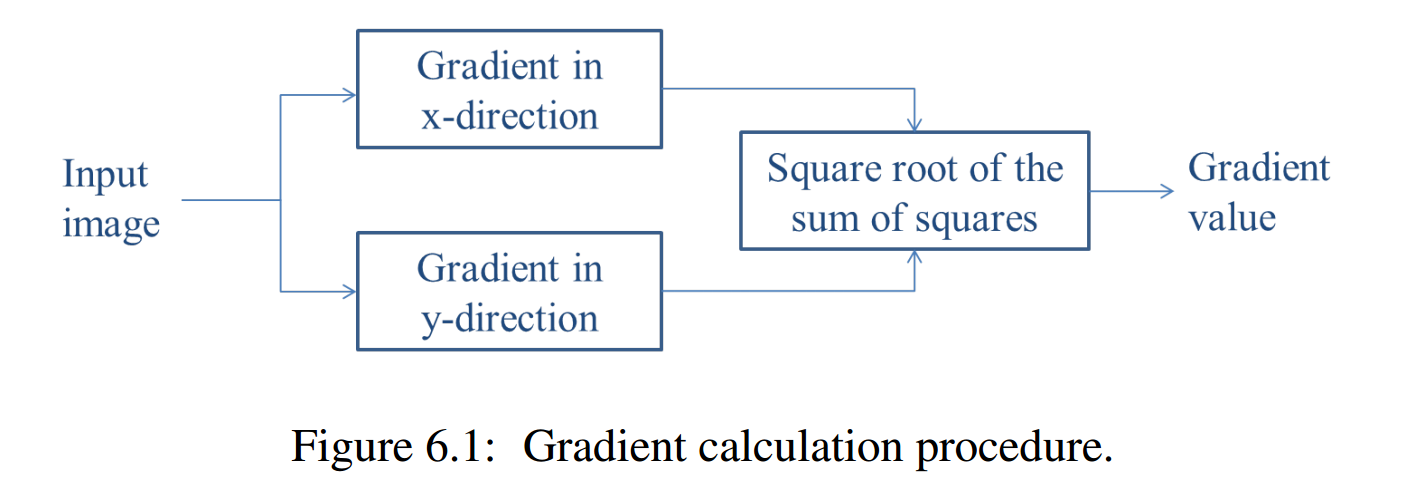

Applying the Sobel and the Prewitt operator on an image can be done with the functions [skimage.filters.sobel()](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.sobel) and [skimage.filters.prewitt()](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.prewitt), respectively.

## Example:

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Images/moon.tif')
moon = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sobel_gradient = sobel(moon) #Apply the Sobel operator

plt.figure(figsize=(8,8))
plt.imshow(sobel_gradient, cmap='gray') #Visualizing the gradients

### **6.4.2 Problems**

1. Read the image 4.2.07.tiff from the USC-SIPI database. Apply the Sobel and the Prewitt operator to this image to estimate its edges. Display the results and comment on them.

In [ ]:
# Write-in your solution
url = 'https://sipi.usc.edu/database/download.php?vol=misc&img=4.2.07'
img = skimage.io.imread(url, plugin = 'pil')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sobel_gradient = sobel(img) #Apply the Sobel operator
prewitt_gradient = skimage.filters.prewitt(img)

plt.imshow(sobel_gradient, cmap='gray') #Visualizing the gradients
plt.show()
plt.imshow(prewitt_gradient, cmap='gray')
plt.show()

Ovi operatori daju slične rezultate jer su im matrice gotovo podjenake, jedino Sobel operator ističe više piksele koji su bliže sredini slike zato su na paprici rubovi istaknutiji.

## 6.4.3 Compass operators for edge detection

Gradient-based methods estimate the gradient in two directions. Compass operators detect edges oriented at a certain angle. Examples of the masks (of size 3 × 3) for angles 0, 45 and 90 degrees can be generated as shown below.

## Example:

In [ ]:
#0 degree angle mask
h0 = np.array([[1, 1, 1],
               [0, 0, 0],
               [-1, -1, -1]])

#45 degree angle mask
h45 = np.array([[1, 1, 0],
                [1, 0, -1],
                [0, -1, -1]])

#90 degree angle mask
h90 = np.array([[1, 0, -1],
                [1, 0, -1],
                [1, 0, -1]])

Convolution of an image with the selected compass operator results in an image with emphasized edges at the selected angle.

### **6.4.4 Problems**

1. Read the image 4.2.07.tiff from the USC-SIPI database. Apply several compass operators on this
image (for different directions).

*Hint: try using the [scipy.signal.convolve2d()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html) function*

In [ ]:
# Write-in your solution
import scipy
url = 'https://sipi.usc.edu/database/download.php?vol=misc&img=4.2.07'
img = skimage.io.imread(url, plugin = 'pil')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

edge_0 = scipy.signal.convolve2d(img, h0)
edge_45 = scipy.signal.convolve2d(img, h45)
edge_90 = scipy.signal.convolve2d(img, h90)

plt.imshow(edge_0,cmap='gray')
plt.show()
plt.imshow(edge_45,cmap='gray')
plt.show()
plt.imshow(edge_90,cmap='gray')
plt.show()

2. What happens with the edges positioned in the direction that does not correspond to the specific
operator?

Rubovi koji su pod kutevima koje operator ne uzima u izračun su manje istaknuti, a rubovi koji su ortogonalni na kut kompas operatora se ne vide.

3. Calculate and display the frequency characteristics for the selected compass operators. (This can be
done with the function [scipy.fft.fft2()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft2.html) as described in the Exercise 3.)

In [ ]:
# Write-in your solution
# Compute Fourier transform
imgFT = fft2(h0) 
imgFT = imgFT*2/np.prod(np.shape(imgFT)) 

# Shift central frequency (0) to image center for displaying - this isn't necessary but it can be visually more suitable
imgFT = fftshift(imgFT)  

# Compute the amplitude and phase spectra
A = np.log10(np.abs(imgFT)) # amplitude in dB
phi = np.angle(imgFT)

plt.imshow(A, cmap='gray')
plt.show()
plt.imshow(phi, cmap='gray')
plt.show()

imgFT = fft2(h45) 
imgFT = imgFT*2/np.prod(np.shape(imgFT)) 

# Shift central frequency (0) to image center for displaying - this isn't necessary but it can be visually more suitable
imgFT = fftshift(imgFT)  

# Compute the amplitude and phase spectra
A = np.log10(np.abs(imgFT)) # amplitude in dB
phi = np.angle(imgFT)

plt.imshow(A, cmap='gray')
plt.show()
plt.imshow(phi, cmap='gray')
plt.show()


imgFT = fft2(h90) 
imgFT = imgFT*2/np.prod(np.shape(imgFT)) 

# Shift central frequency (0) to image center for displaying - this isn't necessary but it can be visually more suitable
imgFT = fftshift(imgFT)  

# Compute the amplitude and phase spectra
A = np.log10(np.abs(imgFT)) # amplitude in dB
phi = np.angle(imgFT)

plt.imshow(A, cmap='gray')
plt.show()
plt.imshow(phi, cmap='gray')
plt.show()

4. Why is their resolution so small?

Malih su dimenzija.

## 6.4.5 Laplacian operator for edge detection

Gradient masks give the best result in cases when there are sudden edges, ie. large change in the pixel intensity values. For the ”softer” edges, methods using estimations based on the second derivatives give better results. 

An example of such estimation is the Laplacian operator. Applying the Laplacian operator on an image can be simply done by using the function [skimage.filters.laplace()](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.laplace).

## Example:

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Images/moon.tif')
moon = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

lap_gradient = laplace(moon) #Apply the Sobel operator

plt.figure(figsize=(8,8))
plt.imshow(lap_gradient, cmap='gray') #Visualizing the gradients

### **6.4.6 Problems**

1. Read the image 4.2.07.tiff from the USC-SIPI database. Apply the Laplacian operator approximation on this image. Display
the results and comment on them.

In [ ]:
# Write-in your solution
url = 'https://sipi.usc.edu/database/download.php?vol=misc&img=4.2.07'
img = skimage.io.imread(url, plugin = 'pil')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

lap_gradient = laplace(img) #Apply the Sobel operator

plt.figure(figsize=(8,8))
plt.imshow(lap_gradient, cmap='gray') #Visualizing the gradients

Laplaceov operator se koristi kada prijelazi nisu toliko nagli, što ovdje nije slučaj zato se bolje rubovi kod ove slike očitavaju pomoću kompas operatora.

# 6.5 Texture features

Textures are present in almost every image. In this part of the exercise, we will use the $2^{nd}$ order histogram features to represent texture features. For that purpose, we will use the function *rowfilter()* to calculate each feature on the window (of the defined size) in the input image.

## Example:

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Images/testpat1.tif')
testpat1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

testpat1 = testpat1.astype('float32') #Convert to decimal format

img = nlfiltShift(testpat1, 
                  (16, 16), 
                  inertia, 
                  shift = (2, 2)); #Process the image

#Display the image
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')

You can notice that for calculating the second order histogram, we need to define the relative spatial relation between the two pixels, i.e. a shift vector, p = (dy, dx), which corresponds to the shift between the two pixels under observation. 

This can be a problem since even for small neighborhoods the number of possibilities is very large.

Therefore, to reduce the calculation time, select the images with smaller dimensiona and choose a smaller neighborhood size. Also, have in mind that the shift vector p has to be smaller than the neighborhood size.

### **6.5.1 Problems**

1. Read the image texture.png, which contains 5 different areas: 3 textures and 2 plain areas. Calculate various features with the functions defined in the beginning of the exercise, i.e. *absolute()*, *inertia()*, *energy()*, *entropy()*, and *covariance()*. 
For each of them try each of these shifts: (2, 2), (3, 3) and (3, 5). Define the window size as (12, 12).
Display the results and comment on them.

In [ ]:
# Write-in your solution
img = cv2.imread('/content/drive/MyDrive/Images/teksture.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img.astype('float32') 

print("absolute")
img1 = nlfiltShift(img, (12,12), absolute, shift=(2,2))
img2 = nlfiltShift(img, (12,12), absolute, shift=(3,3))
img3 = nlfiltShift(img, (12,12), absolute, shift=(3,5))
# Plot the original, the noisy, and both filtered images
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
axs[0, 0].imshow(img, cmap='gray')
axs[1, 1].imshow(img1, cmap='gray')
axs[0, 1].imshow(img2, cmap='gray')
axs[1, 0].imshow(img3, cmap='gray')
fig.show()

print("inertia")
img1 = nlfiltShift(img, (12,12), inertia, shift=(2,2))
img2 = nlfiltShift(img, (12,12), inertia, shift=(3,3))
img3 = nlfiltShift(img, (12,12), inertia, shift=(3,5))
# Plot the original, the noisy, and both filtered images
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
axs[0, 0].imshow(img, cmap='gray')
axs[1, 1].imshow(img1, cmap='gray')
axs[0, 1].imshow(img2, cmap='gray')
axs[1, 0].imshow(img3, cmap='gray')
fig.show()

print("energy")
img1 = nlfiltShift(img, (12,12), energy, shift=(2,2))
img2 = nlfiltShift(img, (12,12), energy, shift=(3,3))
img3 = nlfiltShift(img, (12,12), energy, shift=(3,5))
# Plot the original, the noisy, and both filtered images
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
axs[0, 0].imshow(img, cmap='gray')
axs[1, 1].imshow(img1, cmap='gray')
axs[0, 1].imshow(img2, cmap='gray')
axs[1, 0].imshow(img3, cmap='gray')
fig.show()

print("entropy")
img1 = nlfiltShift(img, (12,12), entropy, shift=(2,2))
img2 = nlfiltShift(img, (12,12), entropy, shift=(3,3))
img3 = nlfiltShift(img, (12,12), entropy, shift=(3,5))
# Plot the original, the noisy, and both filtered images
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
axs[0, 0].imshow(img, cmap='gray')
axs[1, 1].imshow(img1, cmap='gray')
axs[0, 1].imshow(img2, cmap='gray')
axs[1, 0].imshow(img3, cmap='gray')
fig.show()

print("covariance")
img1 = nlfiltShift(img, (12,12), covariance, shift=(2,2))
img2 = nlfiltShift(img, (12,12), covariance, shift=(3,3))
img3 = nlfiltShift(img, (12,12), covariance, shift=(3,5))
# Plot the original, the noisy, and both filtered images
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
axs[0, 0].imshow(img, cmap='gray')
axs[1, 1].imshow(img1, cmap='gray')
axs[0, 1].imshow(img2, cmap='gray')
axs[1, 0].imshow(img3, cmap='gray')
fig.show()

**WRITE YOUR ANSWERS HERE**

2. Select few images that display different textures (you can crop the image to work with images of
smaller dimensions). Select a single feature and calculate it for each of the chosen images.

In [ ]:
# Write-in your solution
img = cv2.imread('/content/drive/MyDrive/Images/tekstura_plast1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img.astype('float32') 

img1 = nlfiltShift(img, (12,12), covariance, shift=(2,2))
img2 = nlfiltShift(img, (12,12), covariance, shift=(3,3))
img3 = nlfiltShift(img, (12,12), covariance, shift=(3,5))
# Plot the original, the noisy, and both filtered images
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(img, cmap='gray')
axs[1, 1].imshow(img1, cmap='gray')
axs[0, 1].imshow(img2, cmap='gray')
axs[1, 0].imshow(img3, cmap='gray')
fig.show()

img = cv2.imread('/content/drive/MyDrive/Images/tekstura_plast2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img.astype('float32') 

img1 = nlfiltShift(img, (12,12), covariance, shift=(2,2))
img2 = nlfiltShift(img, (12,12), covariance, shift=(3,3))
img3 = nlfiltShift(img, (12,12), covariance, shift=(3,5))
# Plot the original, the noisy, and both filtered images
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(img, cmap='gray')
axs[1, 1].imshow(img1, cmap='gray')
axs[0, 1].imshow(img2, cmap='gray')
axs[1, 0].imshow(img3, cmap='gray')
fig.show()

img = cv2.imread('/content/drive/MyDrive/Images/tekstura_plast3.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img.astype('float32') 

img1 = nlfiltShift(img, (12,12), covariance, shift=(2,2))
img2 = nlfiltShift(img, (12,12), covariance, shift=(3,3))
img3 = nlfiltShift(img, (12,12), covariance, shift=(3,5))
# Plot the original, the noisy, and both filtered images
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(img, cmap='gray')
axs[1, 1].imshow(img1, cmap='gray')
axs[0, 1].imshow(img2, cmap='gray')
axs[1, 0].imshow(img3, cmap='gray')
fig.show()

3. Do the features exhibit a sufficient difference to use them for the texture classification?

Značajke kovarijance pokazuju dovoljnu razliku za analizu i klasifikaciju tekstura.

4. Which feature seems the best to perform the classification of the textures in the image?

Za klasifikacija tekstura koristi se kovarijanca